In [100]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [101]:
def plot_all(res_dirs, importer, kind='bar', y='used', 
             variants=[0,1], variant_names=['VANILLA', 'CRYPTONCE'], correct=[], 
             ylabel='CPU Usage (in \%)', ylim=None, figsize=(4, 3), ncols=1,
             space=.1, annotate='improvement', annotate_baseline='VANILLA', annotate_variant='CRYPTONCE', 
             fontsize=8, savefig=None, columnspacing=1):
    baseline = importer(res_dirs[variants[0]][0])
    
    dfs = [importer(res_dirs[i][0]) for i in variants]

    for df_idx, key, val in correct:
        dfs[df_idx].loc[key, y] = val
    
    df = pd.DataFrame()
    df['client'] = dfs[0]['client']
    for df_, name in zip(dfs, variant_names):
        df[name] = df_[y]
    
    df['diff'] = df[annotate_baseline] - df[annotate_variant]
    df['improvement'] = df['diff'] * 100 / df[annotate_baseline]

    with plt.style.context(['science', 'ieee']):
        if kind == 'bar':
            ax = df.plot.bar(x='client', y=variant_names, color=['black', 'red', 'blue', 'green'],
                   grid=True, ylabel=ylabel, ylim=ylim, figsize=figsize, xlabel='Clients')
            plt.xticks(rotation=0)
            
            if annotate is not None:
                for k, i in enumerate(df.index):
                    suffix = "\%" if annotate == "improvement" else ""
                    max_height = df.loc[i, annotate_baseline]  # Position at the higher bar
                    ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}{suffix}', 
                            ha='center', fontsize=fontsize)
            
        elif kind == 'line':
            ax = baseline.plot(
                x='client', y=y, grid=True, color='black', marker='x',
                label=variant_names[0], xlabel='Clients', ylabel=ylabel,
            )
            for df_, name in zip(dfs[1:], variant_names[1:]):
                ax = df_.plot(ax=ax, marker='o', figsize=figsize,
                    x='client', y=y, grid=True, color='red',
                    label=name, xlabel='Clients', ylabel=ylabel, ylim=ylim
                )
        plt.legend(loc='upper left', ncol=ncols, columnspacing=columnspacing)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        plt.show()
    return df

In [102]:
substrings = ["wg", "ksoftirqd"]
ncores = 18
location = None

def parse_scp_file(file):
    _, filesize, run, direction = file.split('.')[0].split('-')
    return filesize, run, direction

def parse_stream_file(file):
    _, _, resolution, run, direction = file.split('.')[0].split('-')
    return resolution, run, direction


def import_scp_file(file, location=location): # kind=stream or scp
    filesize, run, direction = parse_scp_file(file)
    tmp = pd.read_csv(f"{location}/{file}")
    tmp['filesize'] = filesize
    tmp['run'] = run
    tmp['direction'] = direction
    return tmp

def import_stream_file(file, location=location): # kind=stream or scp
    resolution, run, direction = parse_stream_file(file)
    tmp = pd.read_csv(f"{location}/{file}")
    tmp['resolution'] = resolution
    tmp['run'] = run
    tmp['direction'] = direction
    return tmp

def import_sar_net_stream(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'net' in i and "stream" in i]
    dfs = []
    for file in csv_files:
        tmp = import_stream_file(file, location=location)
        tmp = tmp[tmp['iface'] == 'wg-1']
        tmp['rxkB/s'] = tmp['rxkB/s'] * 8e-3
        tmp['rxkB/s'] = tmp['txkB/s'] * 8e-3
        tmp['throughput'] = tmp['rxkB/s'] + tmp['txkB/s']
        tmp.groupby(['resolution', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_sar_net_scp(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'net' in i and "stream" not in i]
    dfs = []
    for file in csv_files:
        tmp = import_scp_file(file, location=location)
        tmp = tmp[tmp['iface'] == 'wg-1']
        tmp['rxkB/s'] = tmp['rxkB/s'] * 8e-3
        tmp['rxkB/s'] = tmp['txkB/s'] * 8e-3
        tmp['throughput'] = tmp['rxkB/s'] + tmp['txkB/s']
        tmp = tmp.groupby(['filesize', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)


def import_pidstat_stream(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" in i]
    dfs = []
    for file in csv_files:
        tmp = import_stream_file(file, location=location)
#         tmp = tmp[tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['resolution', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['resolution', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_pidstat_stream_wg(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" in i]
    dfs = []
    for file in csv_files:
        tmp = import_stream_file(file, location=location)
        tmp = tmp[tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['resolution', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['resolution', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_pidstat_stream_not_wg(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" in i]
    dfs = []
    for file in csv_files:
        tmp = import_stream_file(file, location=location)
        tmp = tmp[~tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['resolution', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['resolution', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_pidstat_scp_not_wg(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" not in i]
    dfs = []
    for file in csv_files:
        tmp = import_scp_file(file, location=location)
        tmp = tmp[~tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['filesize', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['filesize', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_pidstat_scp_wg(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" not in i]
    dfs = []
    for file in csv_files:
        tmp = import_scp_file(file, location=location)
        tmp = tmp[tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['filesize', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['filesize', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_pidstat_scp(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    csv_files = [i for i in os.listdir(location) if 'pidstat' in i and "stream" not in i]
    dfs = []
    for file in csv_files:
        tmp = import_scp_file(file, location=location)
#         tmp = tmp[tmp.command.str.contains("|".join(substrings), case=True, regex=True)]
        tmp = tmp.groupby(['filesize', 'run', 'direction', 'timestamp']).sum(numeric_only=True).reset_index()
        tmp = tmp.groupby(['filesize', 'run', 'direction']).median(numeric_only=True).reset_index()
        dfs.append(tmp)
    return pd.concat(dfs, axis=0)

def import_scp(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    return pd.read_csv(f'{location}/scp.csv')

def import_wrk(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    return pd.read_csv(f'{location}/wrk.csv')

def import_streaming(res_dir):
    location = f"../{prefix}/{res_dir}/summary"
    df = pd.read_csv(f'{location}/streaming.csv')
    df['bitrate'] = df.bitrate.str.replace('kbits/s', '').astype('float')
    return df

In [103]:
def get_metric(
        metric, importer, index, negative=False, normalize=False,
        variants=None, res_dirs=None,
    ):
    dfs = {}

    for res_dir, variant in zip(res_dirs, variants):
        df = importer(res_dir)
#         print(df)
        df['variant'] = variant
        dfs[variant] = df.groupby(index).median(numeric_only=True)

    df = dfs['VANILLA'].reset_index()[index]

    for name, dataframe in dfs.items():
        df[name] = dfs[name].reset_index()[metric]

    df['difference'] = df['CRYPTONCE'] - df['VANILLA']
    if negative:
        df['difference'] = df['difference'] * -1
    df['improvement'] = df['difference'] * 100 / df['VANILLA']
    
    if normalize:
        df['CRYPTONCE'] = df['CRYPTONCE'] / df['VANILLA']
        df['VANILLA'] = df['VANILLA'] / df['VANILLA']
    
    return df

In [104]:
prefix='client-bench-3'

In [105]:
colors = ['black', 'red']
figsize = [4, 3]
fontsize = 5
space = 0.2

In [106]:
res_dirs = os.listdir(f'../{prefix}')
variants = []

for res_dir in res_dirs:
    with open(f"../{prefix}/{res_dir}/EXPERIMENT_DATA/CURRENT_EXP") as f:
        variant = f.read().strip().split('-')[1].upper()
        variants.append(variant)

In [107]:
res_dirs

['results-83c6ac51', 'results-f09c568a']

In [108]:
res_dir = res_dirs[0]
location = f"../{prefix}/{res_dir}/summary"
csv_files = [i for i in os.listdir(location) if 'sar' in i and "stream" in i]

In [109]:
variants = variants
res_dirs = res_dirs

In [110]:
res_dirs

['results-83c6ac51', 'results-f09c568a']

# SCP

In [111]:
importer = import_pidstat_scp_not_wg
index = ['filesize', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df[['CRYPTONCE', 'VANILLA']] / 18

,CRYPTONCE,VANILLA
0,5.491667,5.466111
1,5.794444,5.850139
2,6.111111,6.111111
3,6.472222,6.444444
4,6.194444,6.166667
5,6.527778,6.472222


In [112]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

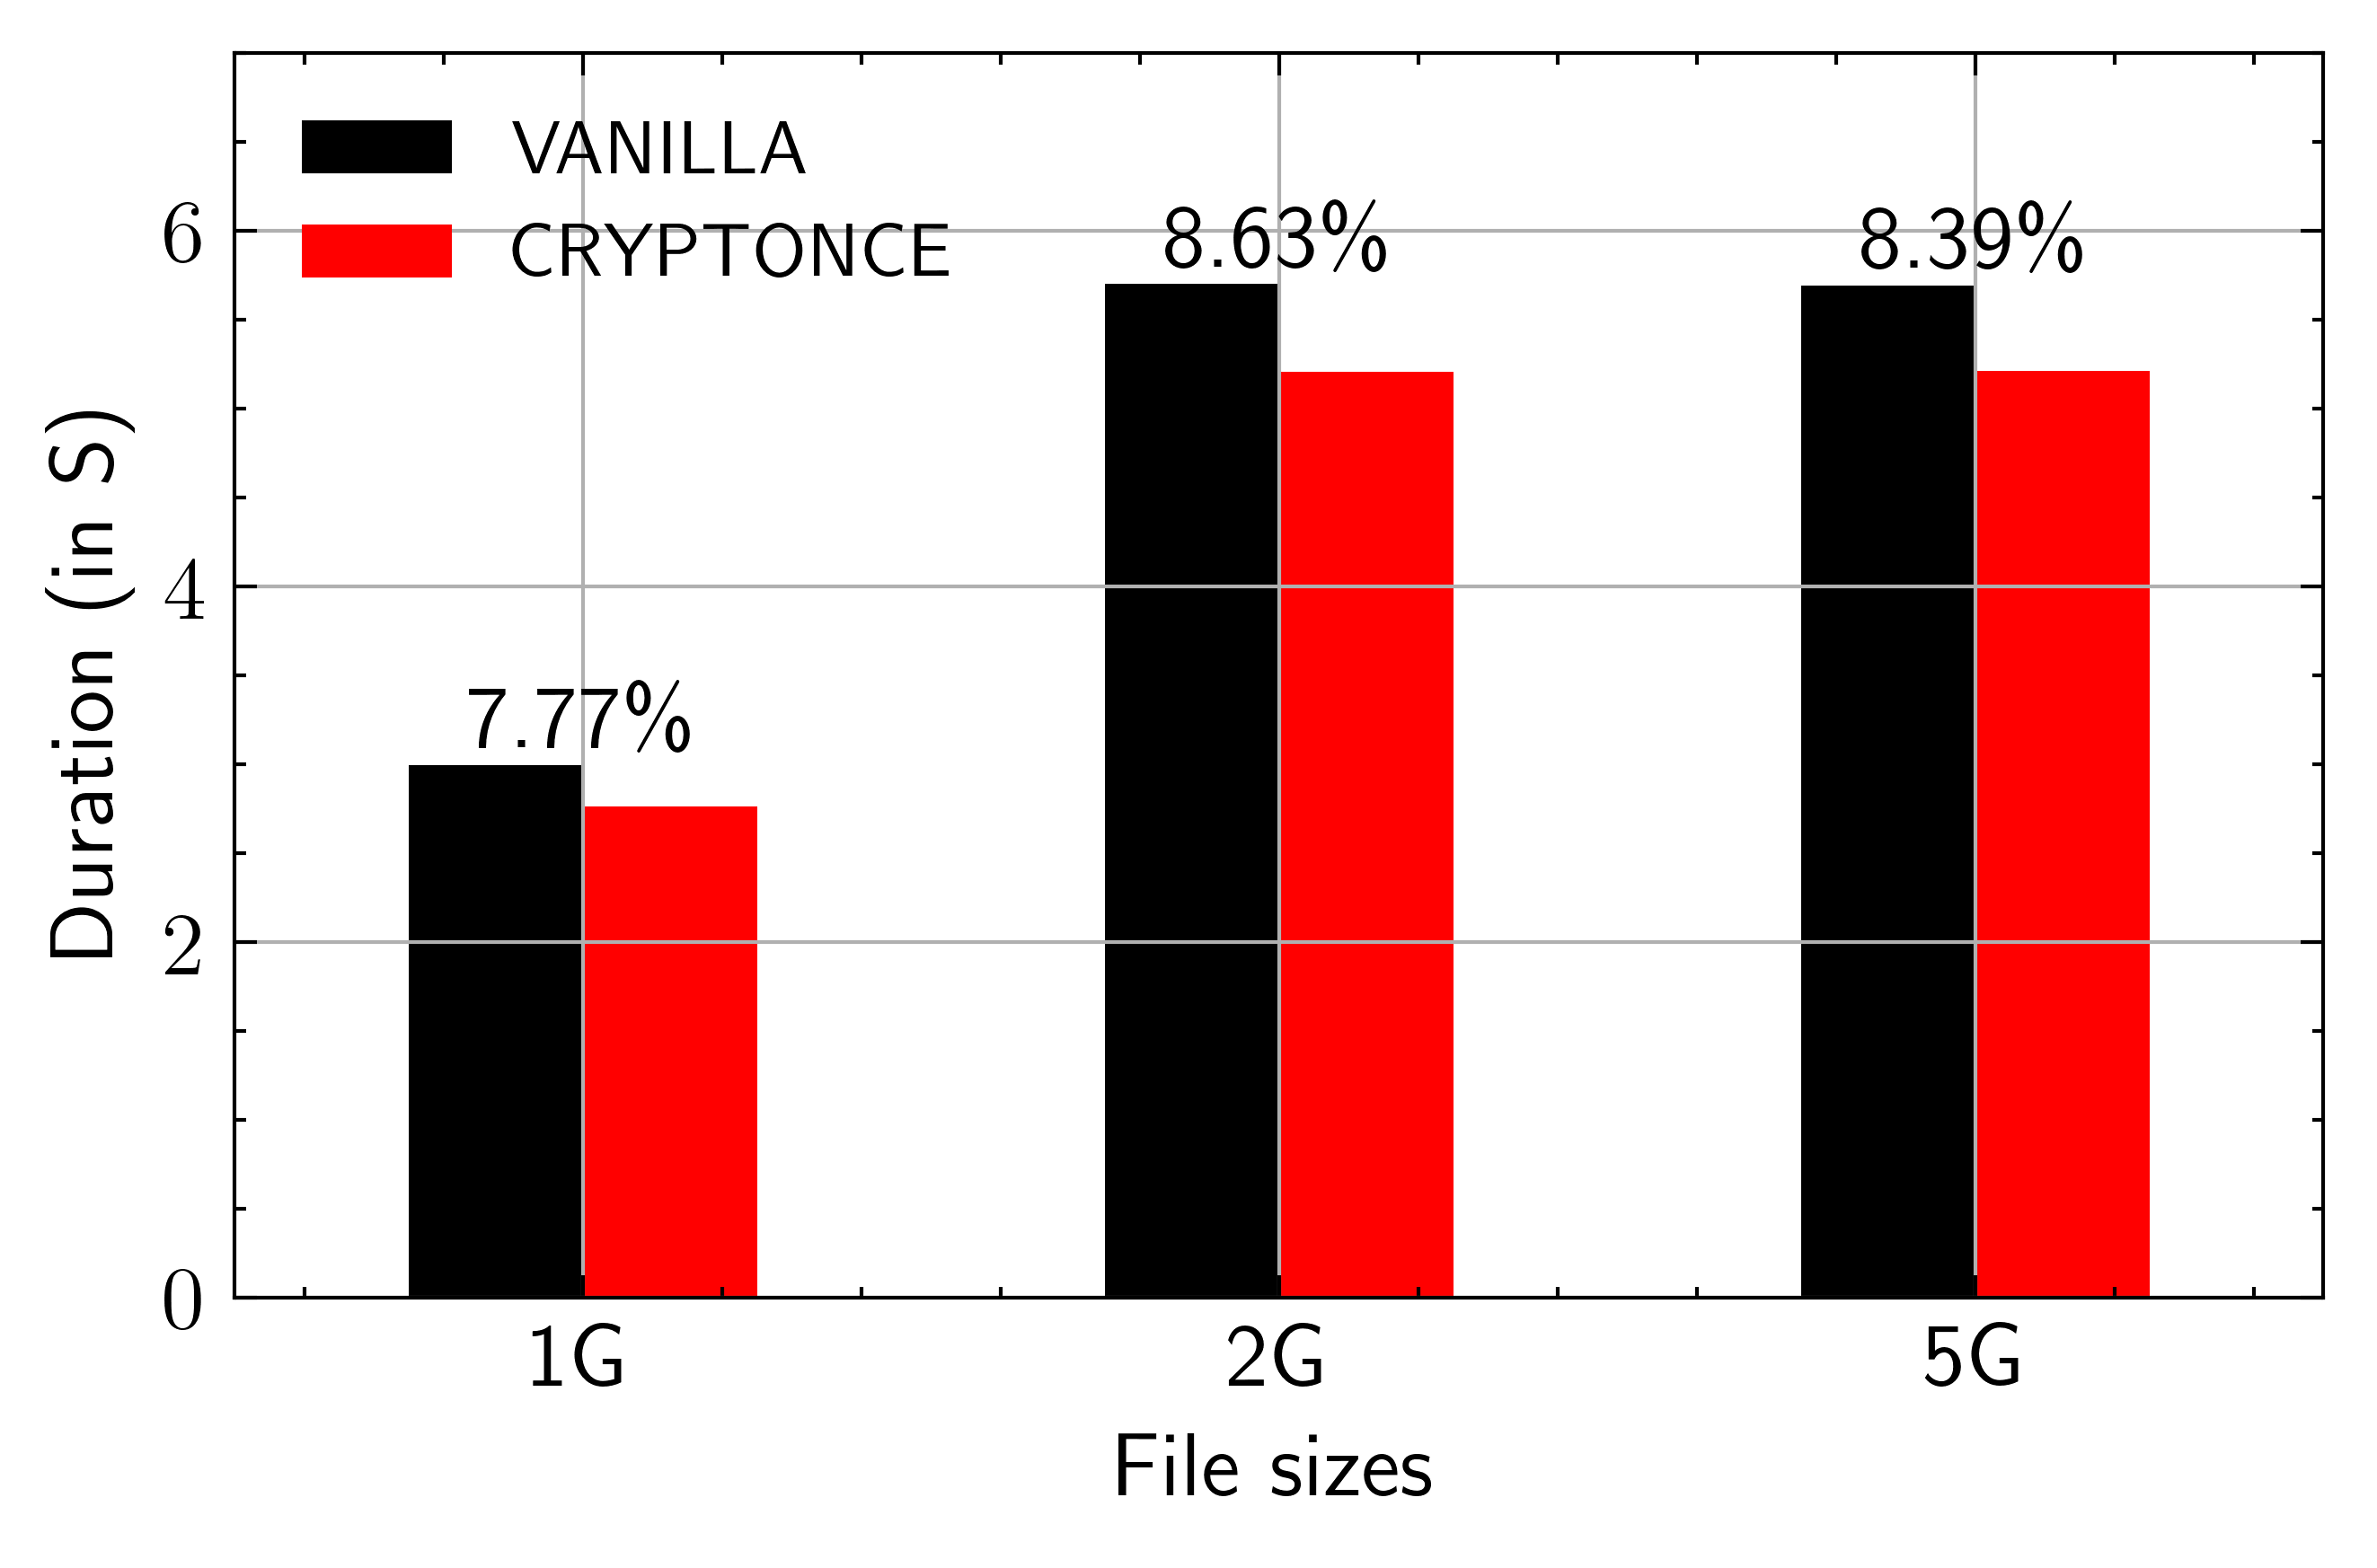

In [113]:
importer = import_scp
index = ['filesize', 'direction']
metric = 'duration'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'upload']

with plt.style.context(['science', 'ieee']):
    ax = df.plot.bar(
        figsize=(5, 3), x='filesize', y=['VANILLA', 'CRYPTONCE'],
        grid=True, color=['black', 'red'], ylabel='Duration (in S)', 
        xlabel="File sizes", ylim=[0, 7]
    )
    plt.xticks(rotation=0)
    
    annotate = 'improvement'
    space = .1
    for k, i in enumerate(df.index):
#         suffix = "\%" if annotate == "improvement" else ""
        max_height = df.loc[i, 'VANILLA']  # Position at the higher bar
        ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}\%', 
                ha='center', fontsize=12)
    plt.legend(loc='upper left', prop = {"size":10})
    plt.savefig("../graphs/scp_duration.pdf", dpi=300)

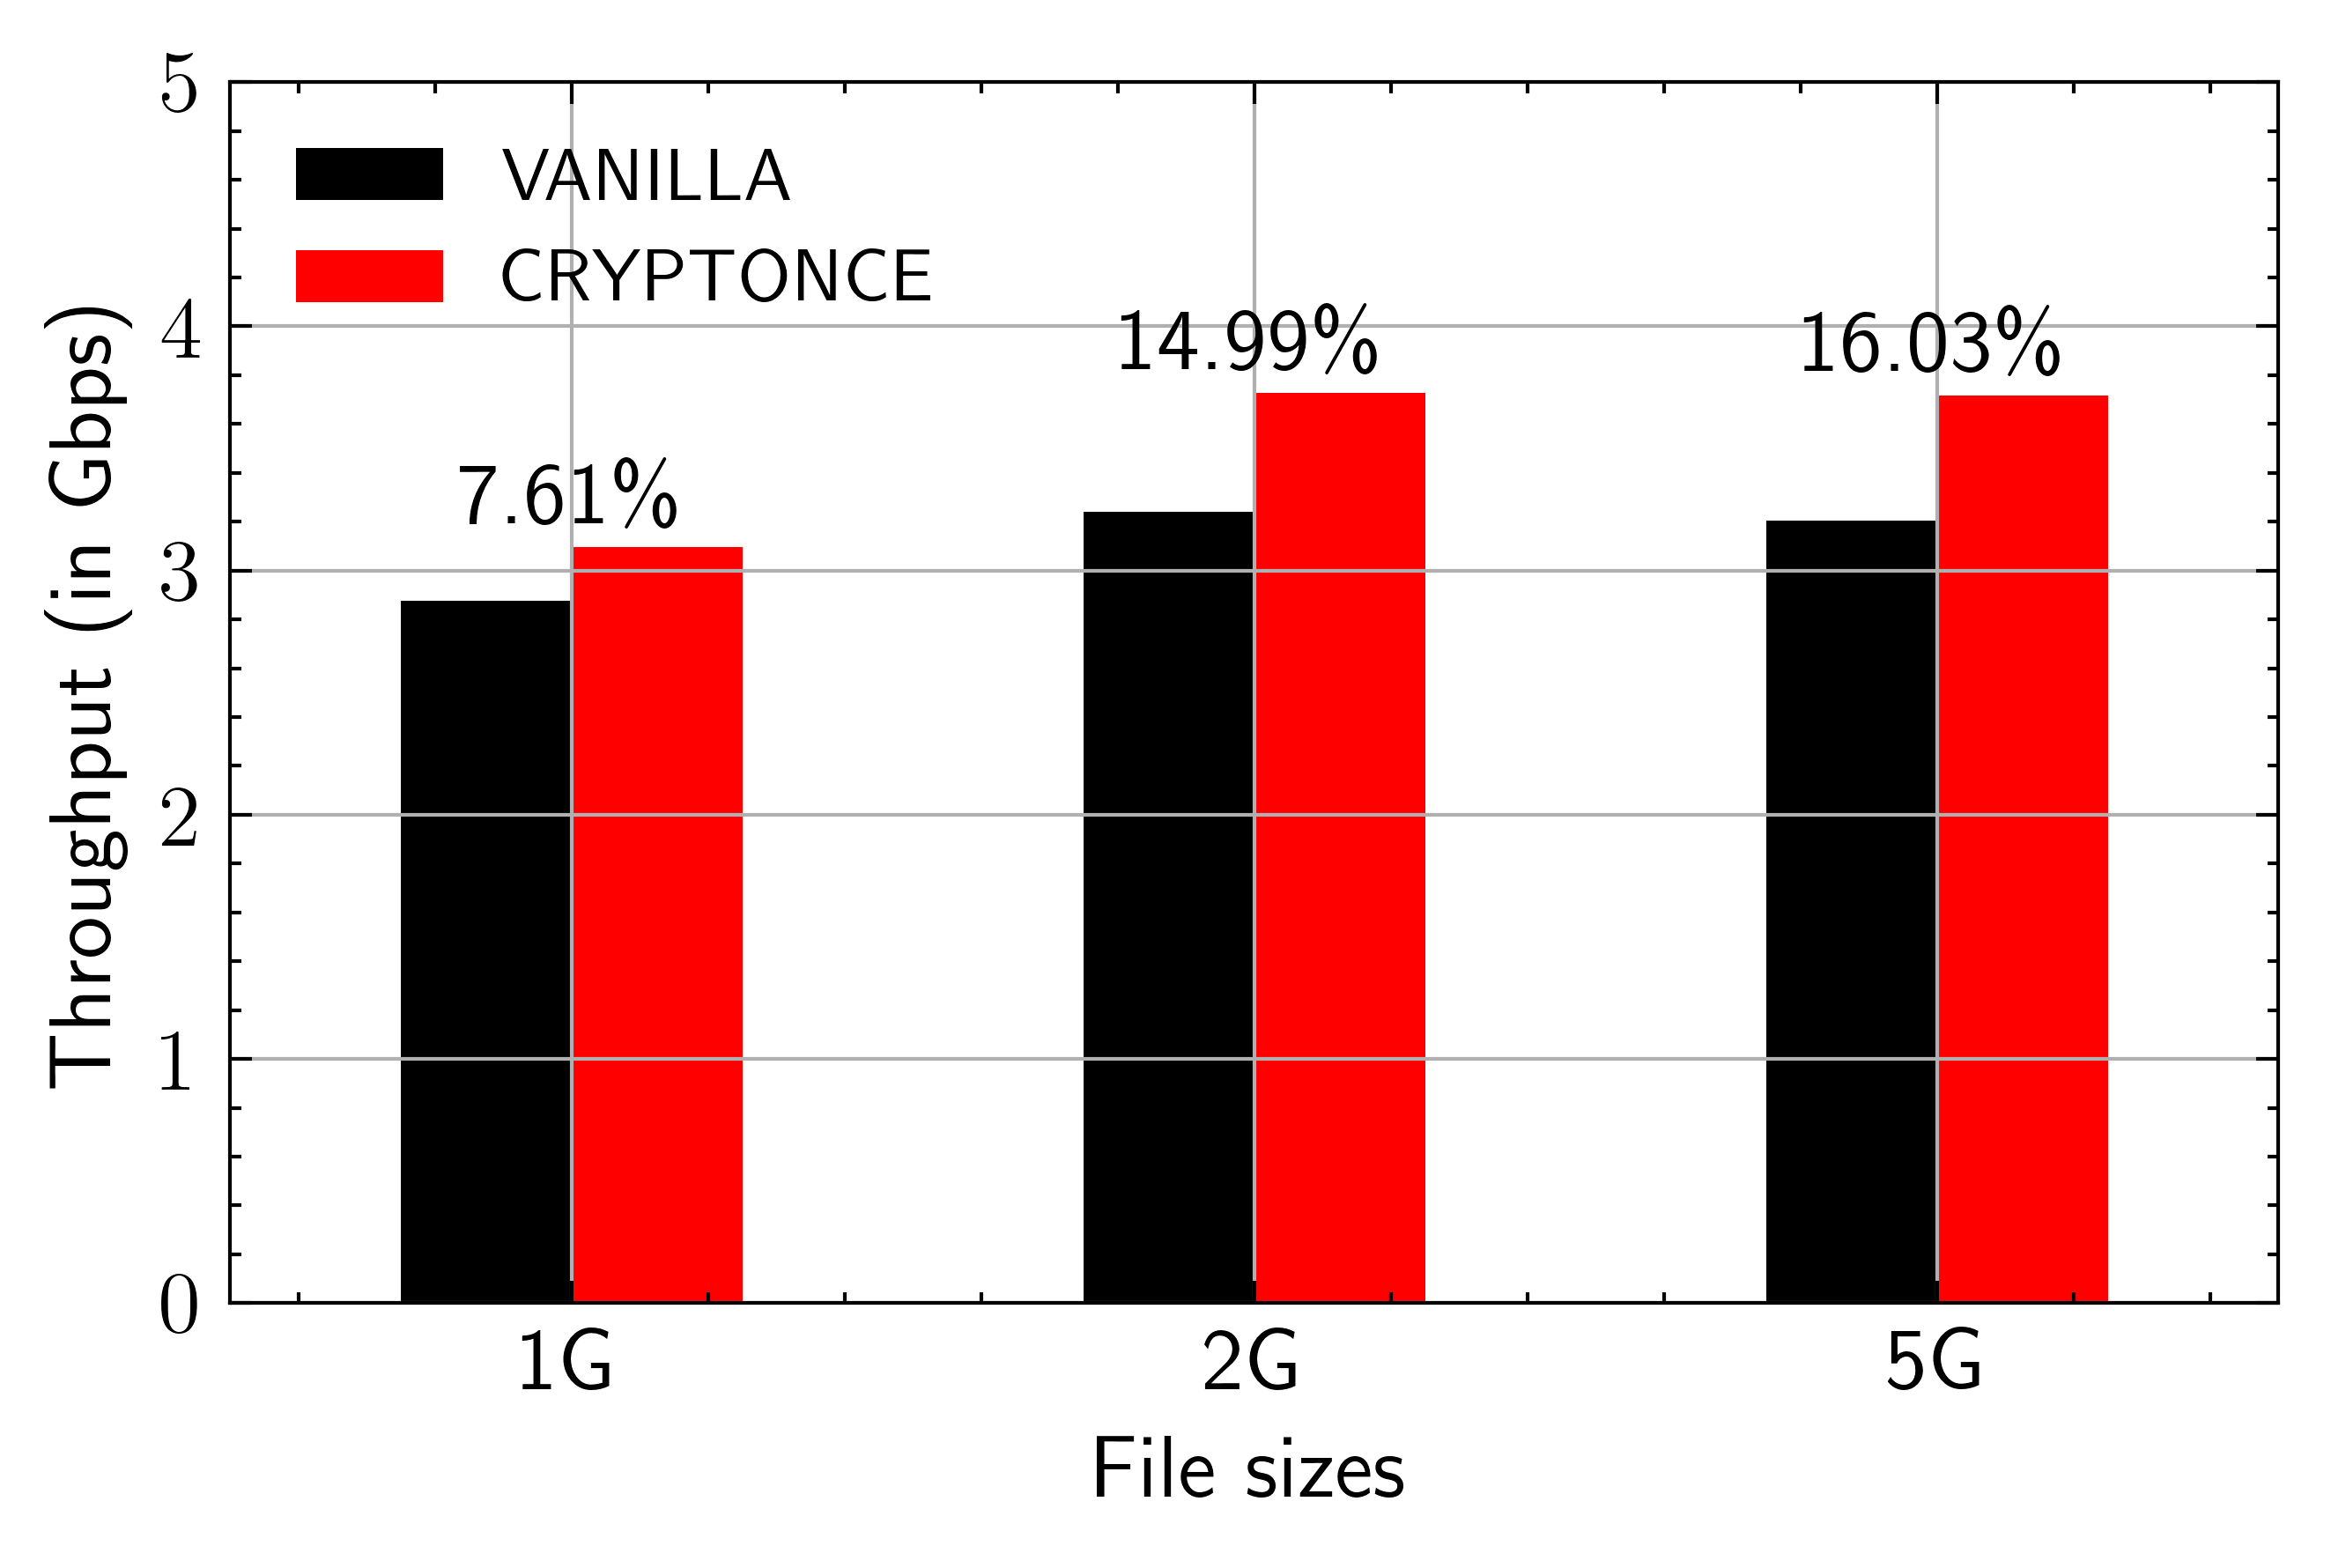

In [114]:
importer = import_sar_net_scp
index = ['filesize', 'direction']
metric = 'throughput'

df = get_metric(importer=importer, index=index, metric=metric, negative=False,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
df[['VANILLA', 'CRYPTONCE', 'difference']] /= (1024*1024)
df[['VANILLA', 'CRYPTONCE', 'difference']] *= 8


with plt.style.context(['science', 'ieee']):
    ax = df.plot.bar(
        figsize=(5, 3), x='filesize', y=['VANILLA', 'CRYPTONCE'],
        grid=True, color=['black', 'red'], ylabel='Throughput (in Gbps)', 
        xlabel="File sizes", ylim=[0, 5]
    )
    plt.xticks(rotation=0)
    
    annotate = 'improvement'
    space = .1
    for k, i in enumerate(df.index):
#         suffix = "\%" if annotate == "improvement" else ""
        max_height = df.loc[i, 'CRYPTONCE']  # Position at the higher bar
        ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}\%', 
                ha='center', fontsize=12)
    plt.legend(loc='upper left', prop = {"size":10})
    plt.savefig("../graphs/scp_throughput.pdf", dpi=300)

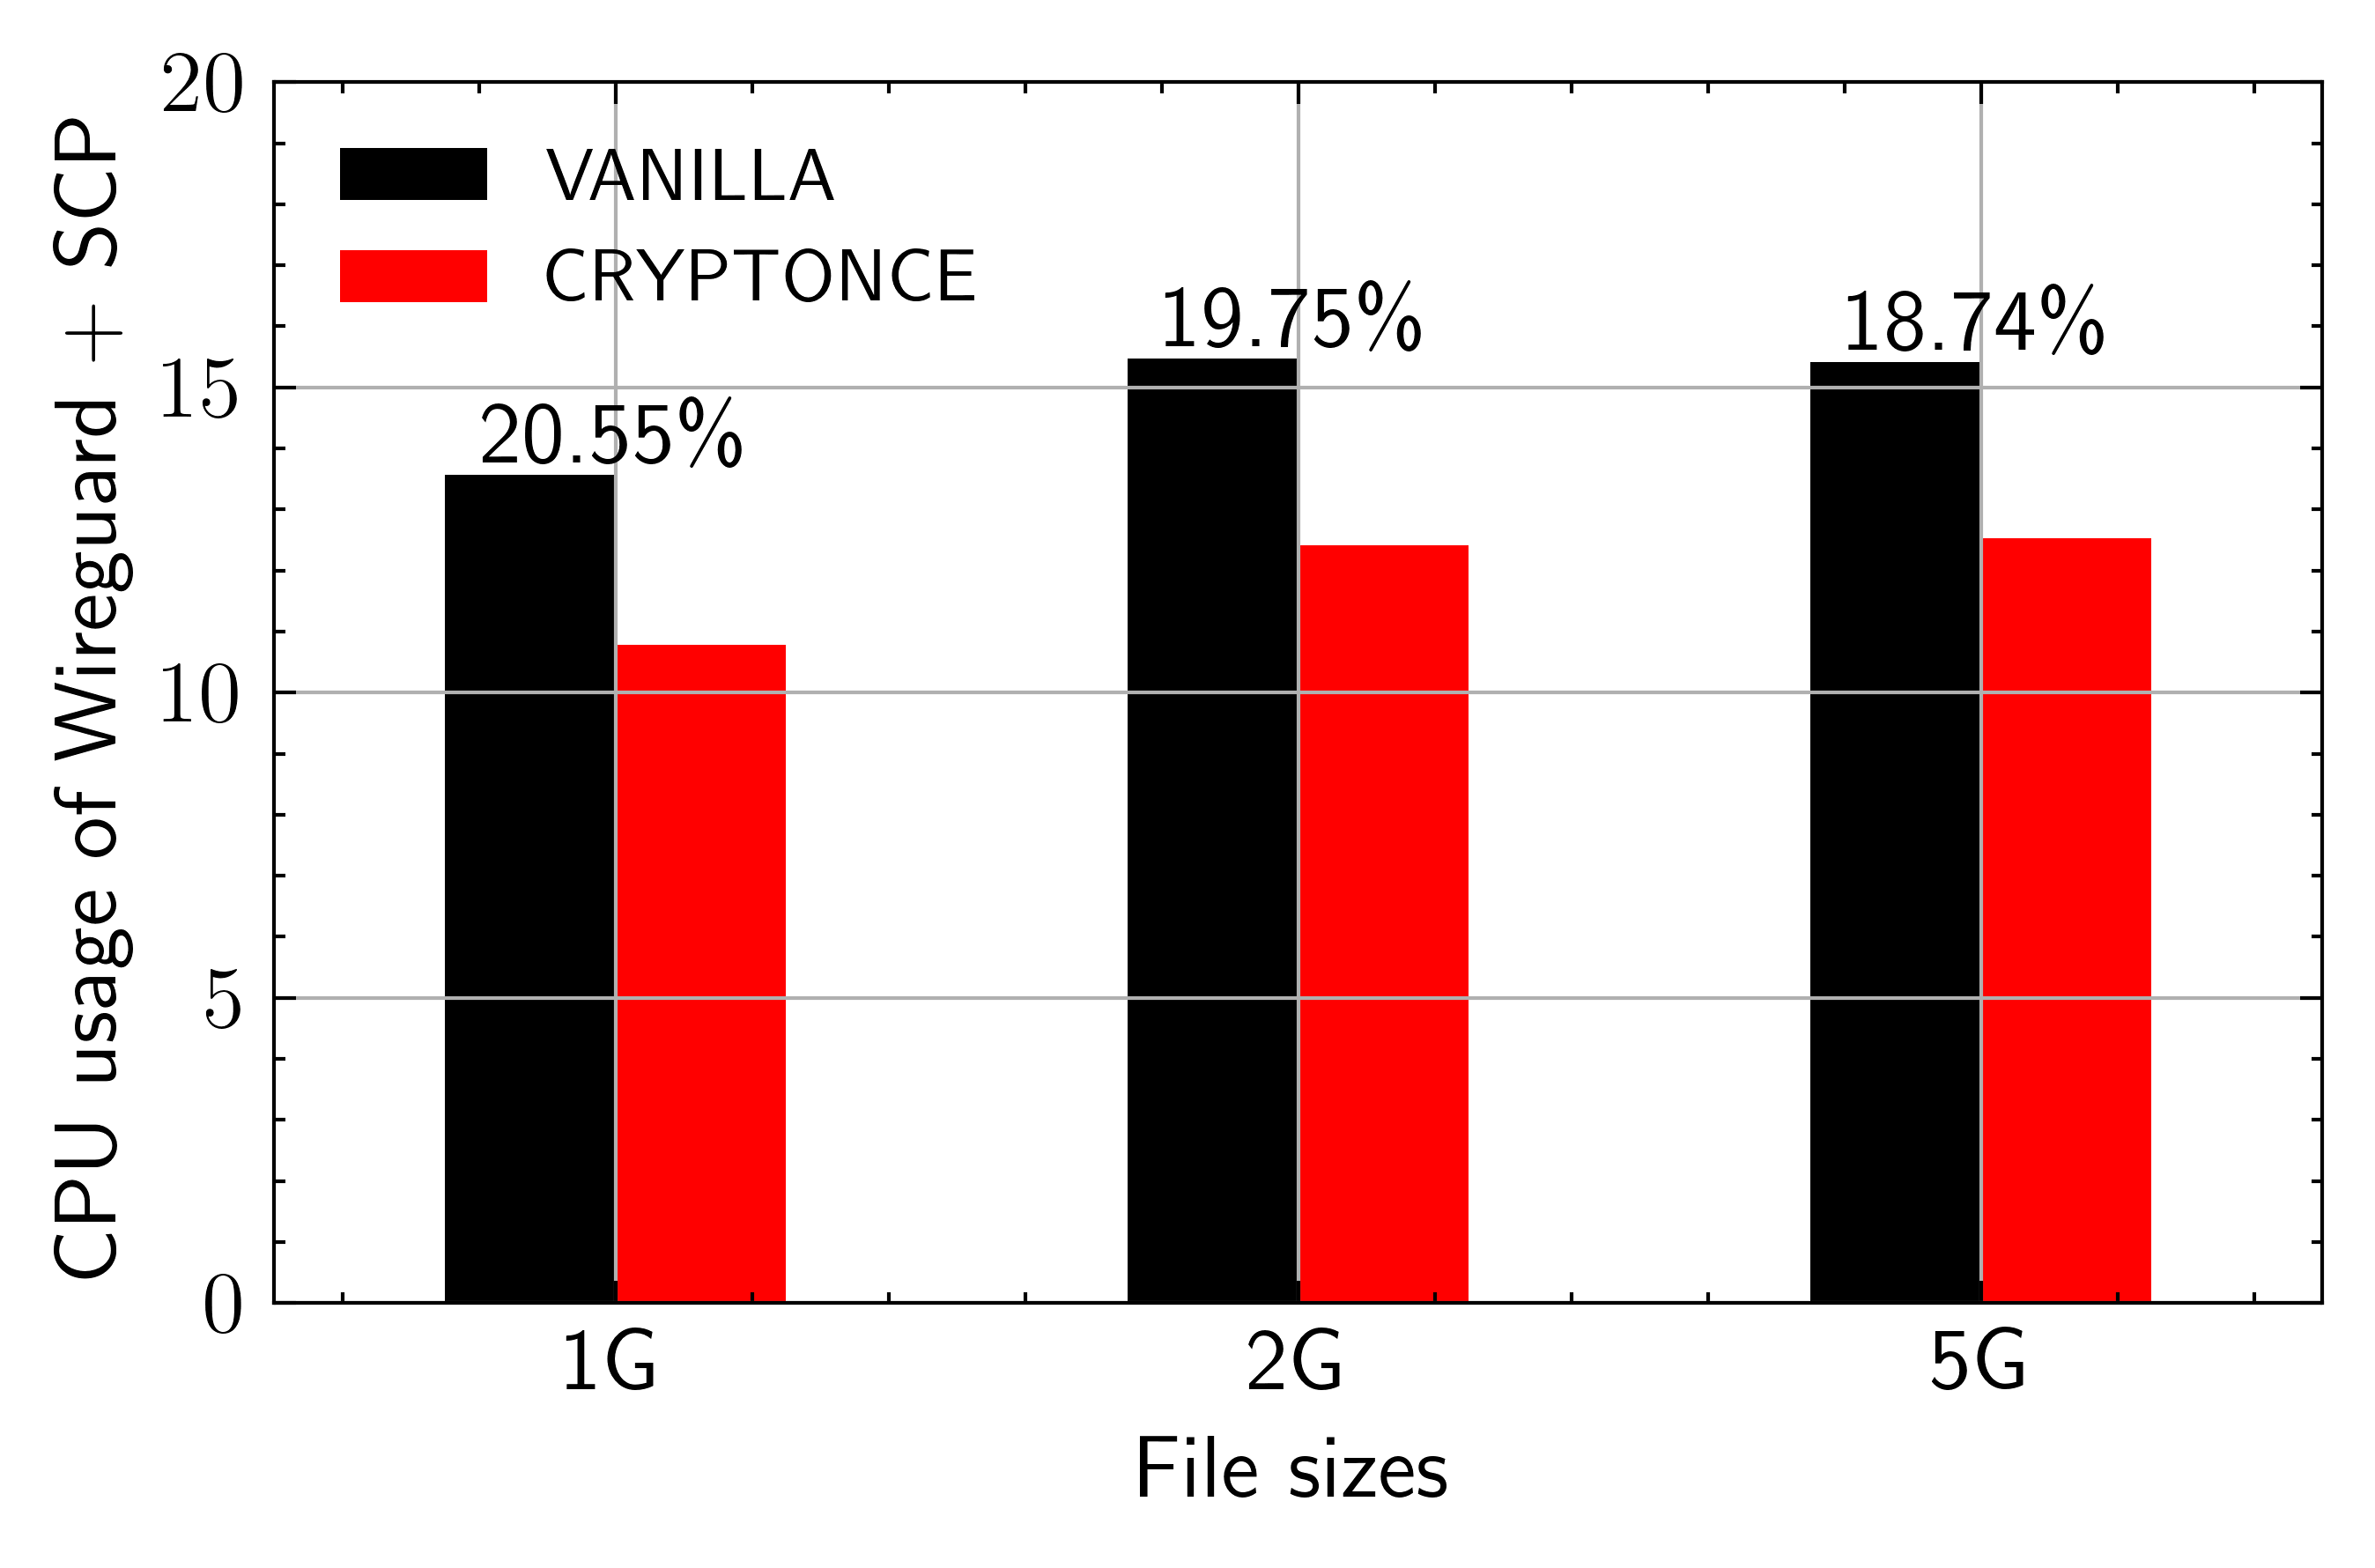

In [115]:
importer = import_pidstat_scp
index = ['filesize', 'direction']
metric = 'used'
cols = ['VANILLA', 'CRYPTONCE']

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
df[cols] /= 18

with plt.style.context(['science', 'ieee']):
    ax = df.plot.bar(
        figsize=(5, 3), x='filesize', y=['VANILLA', 'CRYPTONCE'],
        grid=True, color=['black', 'red'], ylabel='CPU usage of Wireguard + SCP', 
        xlabel="File sizes", ylim=[0, 20]
    )
    plt.xticks(rotation=0)
    
    annotate = 'improvement'
    space = .2
    for k, i in enumerate(df.index):
#         suffix = "\%" if annotate == "improvement" else ""
        max_height = df.loc[i, 'VANILLA']  # Position at the higher bar
        ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}\%', 
                ha='center', fontsize=12)
    plt.legend(loc='upper left', prop = {"size":10})
    plt.savefig('../graphs/scp_cpu_all.pdf', dpi=300)

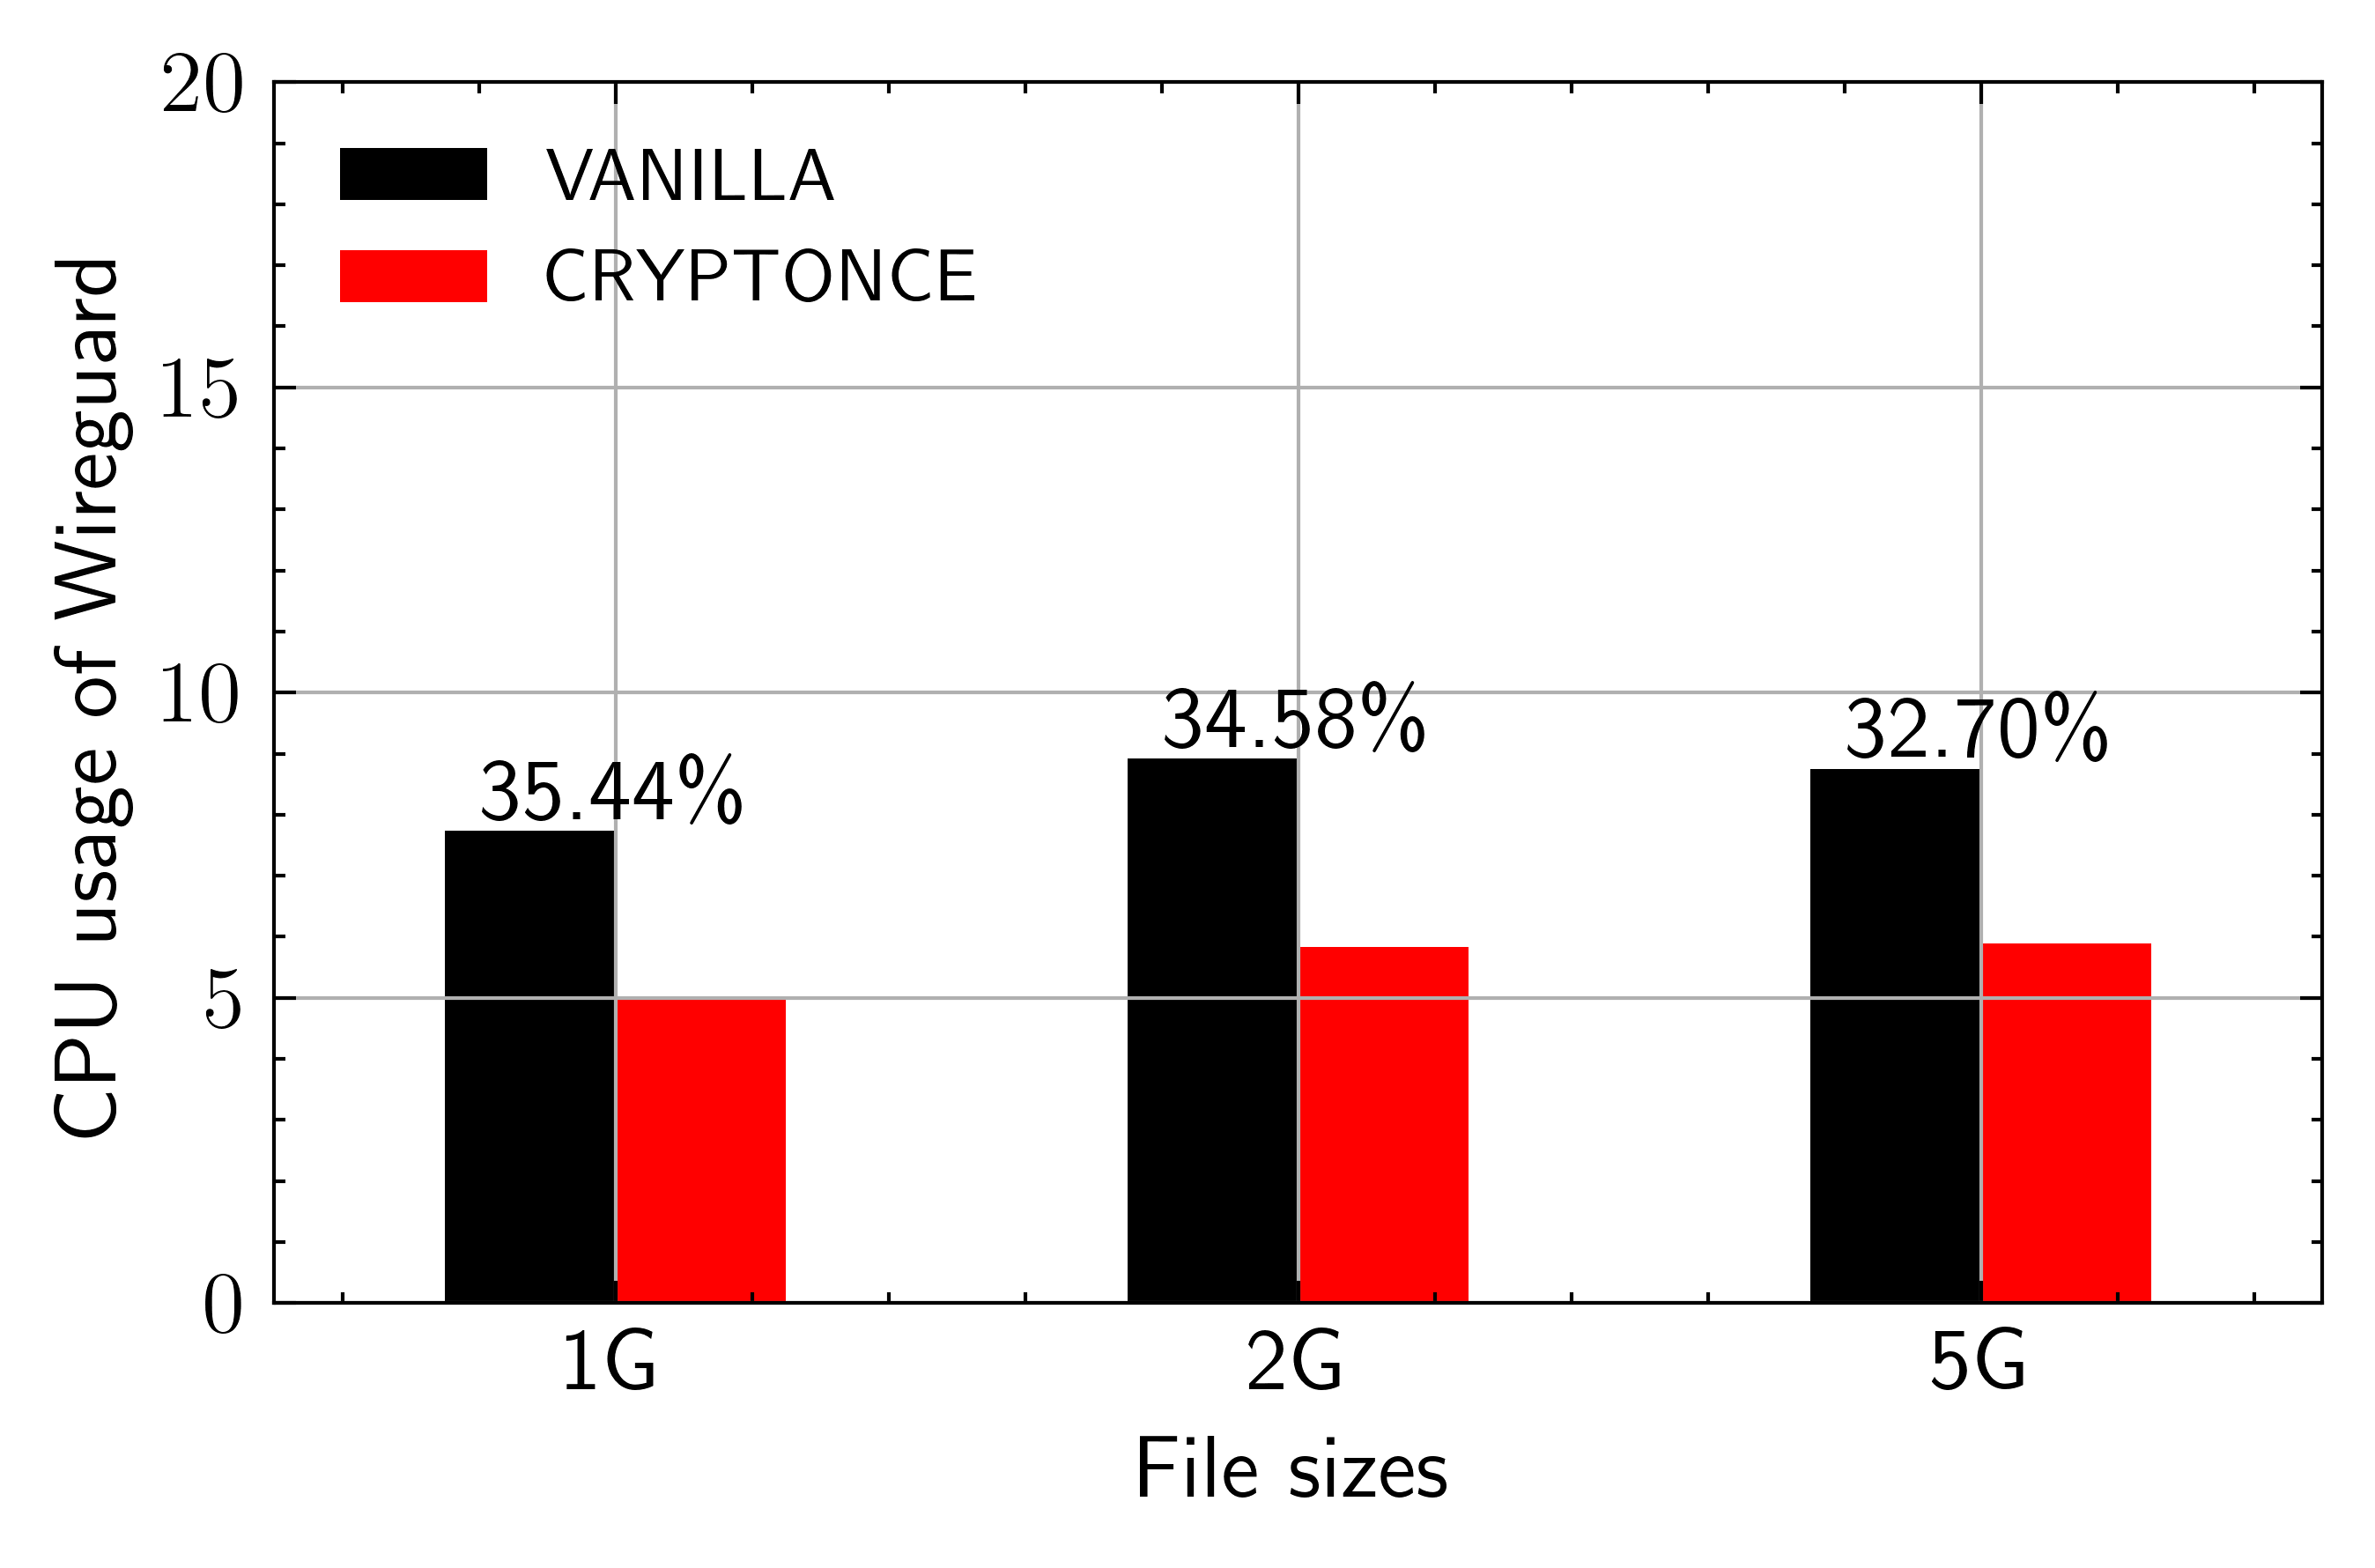

In [116]:
importer = import_pidstat_scp_wg
index = ['filesize', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
df[cols] /= 18

with plt.style.context(['science', 'ieee']):
    ax = df.plot.bar(
        figsize=(5, 3), x='filesize', y=['VANILLA', 'CRYPTONCE'],
        grid=True, color=['black', 'red'], ylabel='CPU usage of Wireguard', 
        xlabel="File sizes", ylim=[0, 20]
    )
    plt.xticks(rotation=0)
    
    annotate = 'improvement'
    space = .2
    for k, i in enumerate(df.index):
#         suffix = "\%" if annotate == "improvement" else ""
        max_height = df.loc[i, 'VANILLA']  # Position at the higher bar
        ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}\%', 
                ha='center', fontsize=12)
    plt.legend(loc='upper left', prop = {"size":10})
    plt.savefig('../graphs/scp_cpu_wg.pdf', dpi=300)

filesize,1G,2G,5G
Duration,7.765347,8.626466,8.394604
Throughput,7.613188,14.986895,16.032650
CPU (WG + SSH),20.552348,19.748654,18.738739
CPU (WG),35.440651,34.579439,32.698413


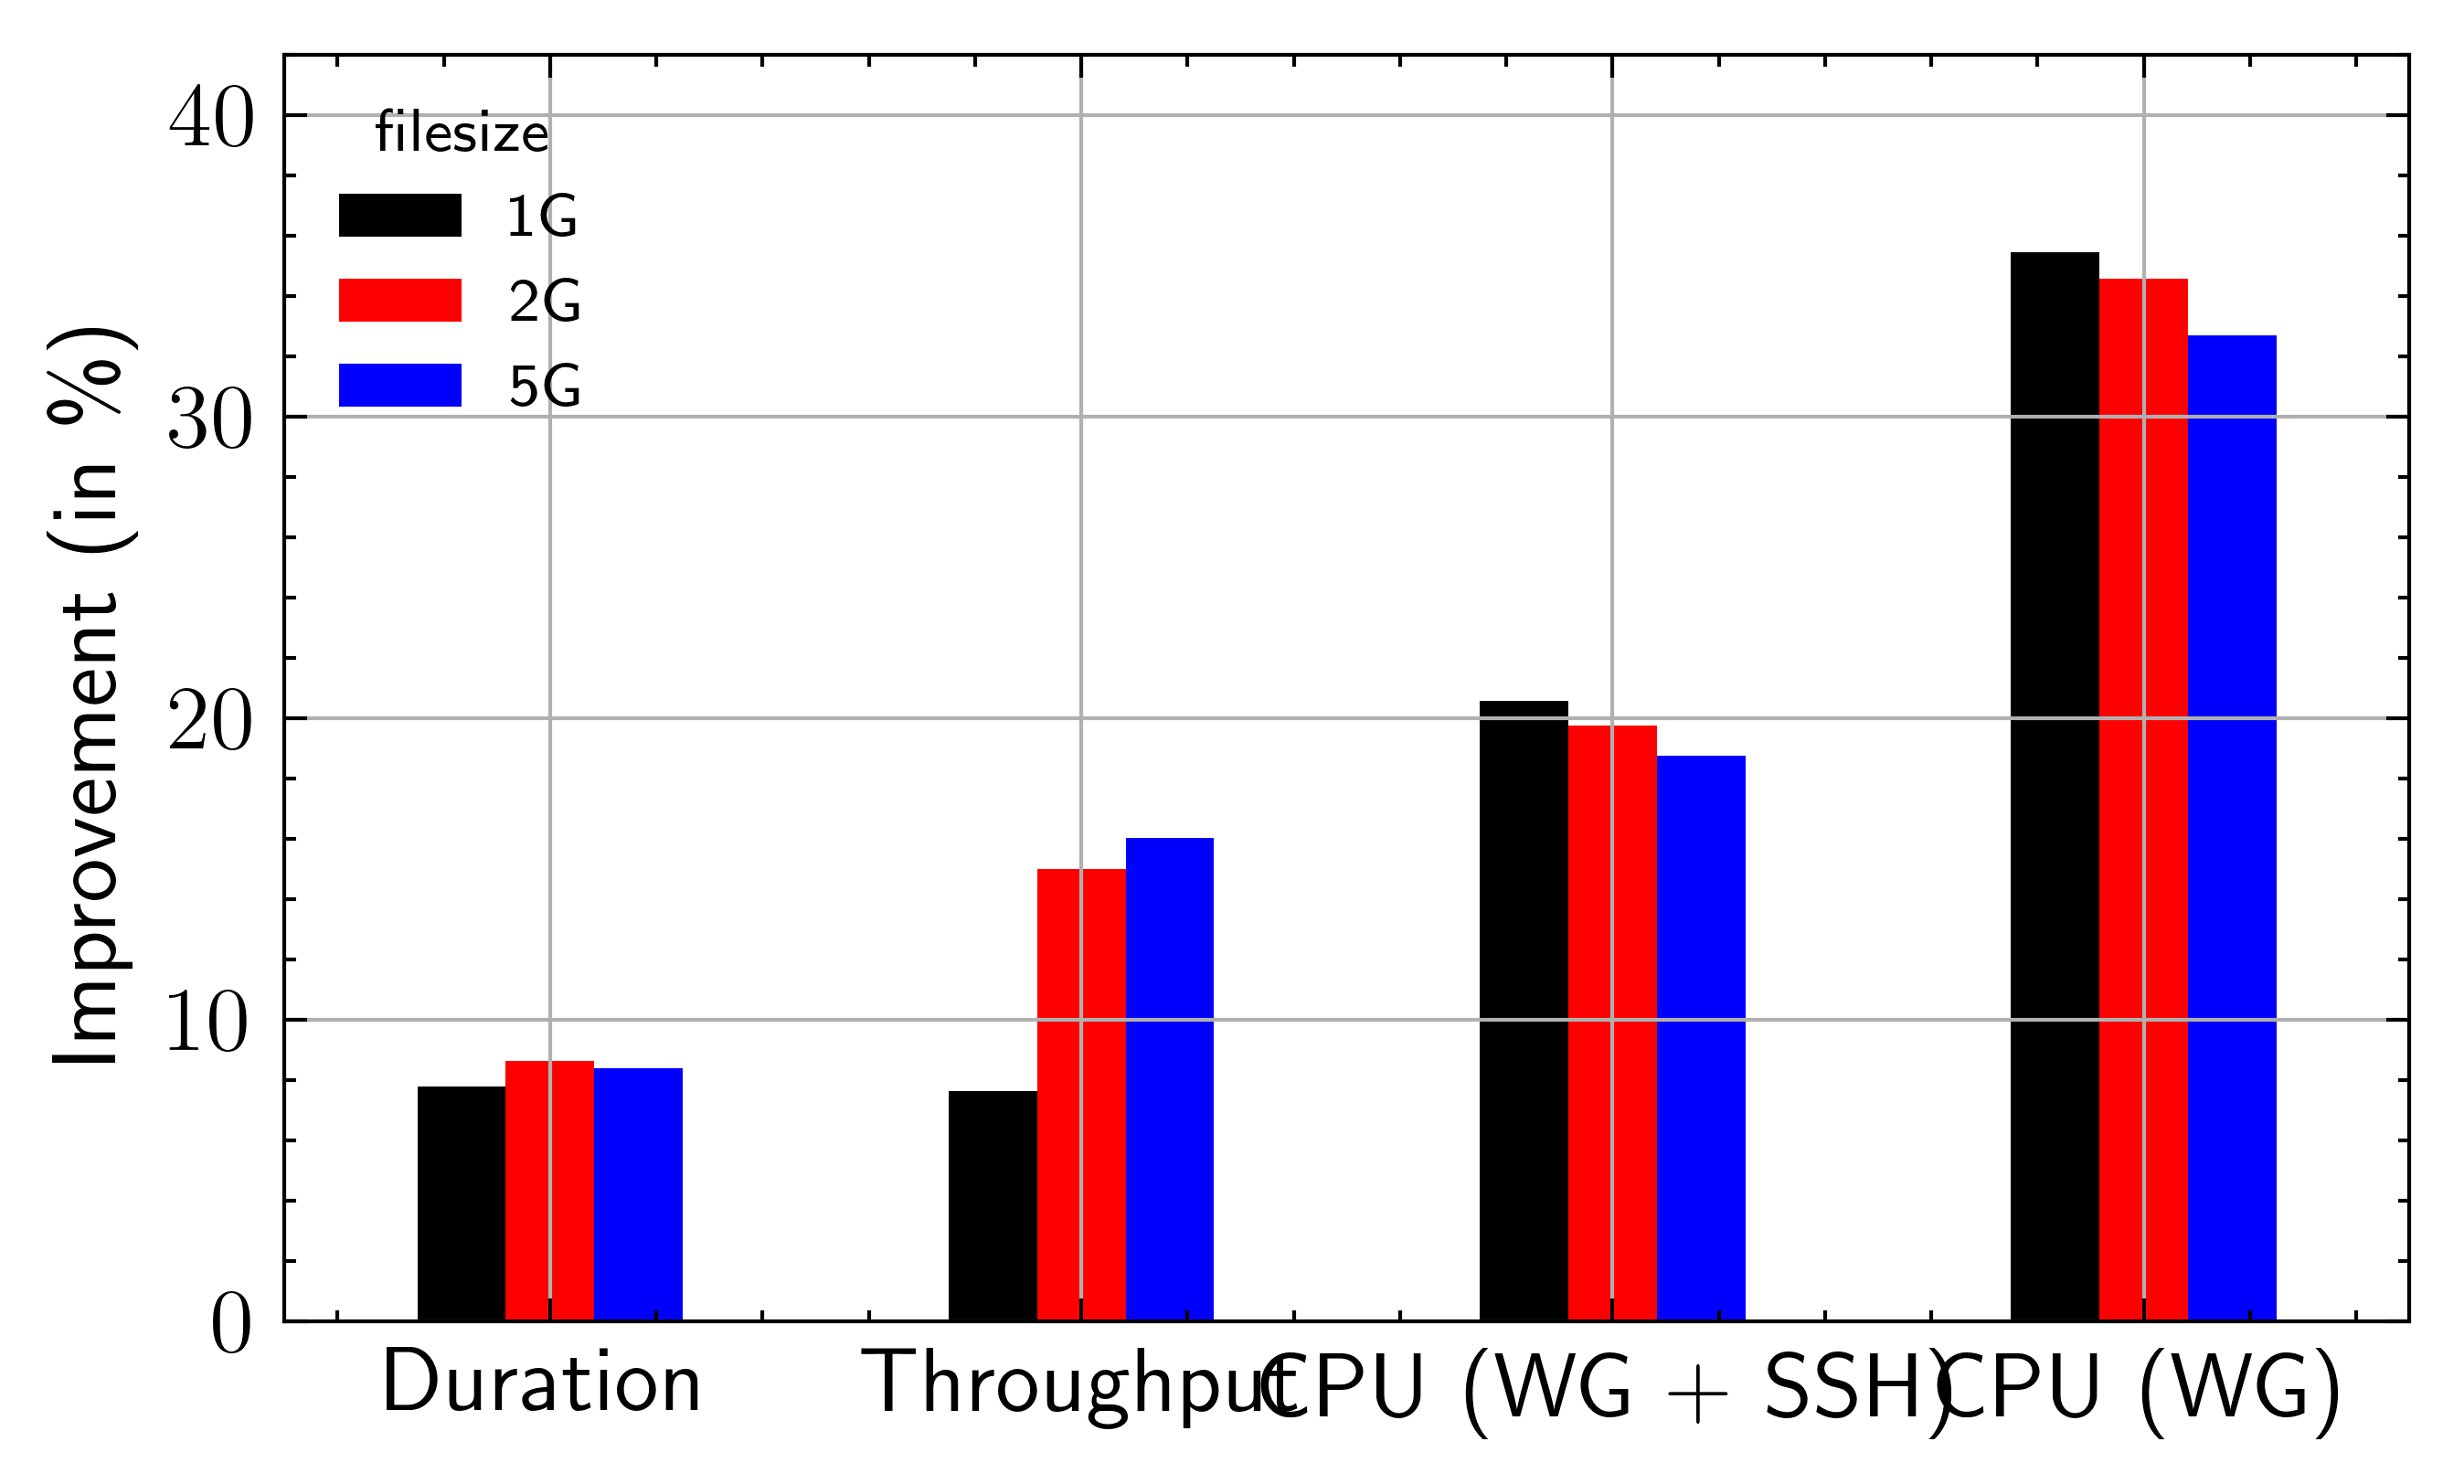

In [117]:
importer = import_scp
index = ['filesize', 'direction']
metric = 'duration'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'upload']
result = df.set_index('filesize')

result['Duration'] = result['improvement']


importer = import_sar_net_scp
index = ['filesize', 'direction']
metric = 'throughput'

df = get_metric(importer=importer, index=index, metric=metric, negative=False,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
impr = df.set_index('filesize')

result['Throughput'] = impr['improvement']


importer = import_pidstat_scp
index = ['filesize', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
impr = df.set_index('filesize')

result['CPU (WG + SSH)'] = impr['improvement']

importer = import_pidstat_scp_wg
index = ['filesize', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True,
               variants=variants, res_dirs=res_dirs)
df = df[df.direction == 'up']
impr = df.set_index('filesize')

result['CPU (WG)'] = impr['improvement']

result = result.drop(['direction', 'CRYPTONCE', 'VANILLA', 'difference', 'improvement'], axis=1)

# result.T.loc['Throughput', '1G'] += 10
with plt.style.context(['science', 'ieee']):
    result.T.plot.bar(
        xlabel="", ylabel="Improvement (in \%)",
        grid=True, figsize=(5, 3), ylim=[0, 42]
    )
    plt.xticks(rotation=0)
    plt.savefig("../graphs/scp.pdf", dpi=400)
result.T

In [118]:
result.T

filesize,1G,2G,5G
Duration,7.765347,8.626466,8.394604
Throughput,7.613188,14.986895,16.032650
CPU (WG + SSH),20.552348,19.748654,18.738739
CPU (WG),35.440651,34.579439,32.698413


# Streaming

## CPU Usage

In [121]:
importer = import_pidstat_stream_not_wg
index = ['resolution', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True, variants=variants, res_dirs=res_dirs)
df

,resolution,direction,VANILLA,CRYPTONCE,difference,improvement
0,1080p,up,101.0,101.0,-0.0,-0.0
1,480p,up,101.0,101.0,-0.0,-0.0
2,720p,up,101.0,101.0,-0.0,-0.0


In [122]:
importer = import_pidstat_stream_wg
index = ['resolution', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True, variants=variants, res_dirs=res_dirs)
df

,resolution,direction,VANILLA,CRYPTONCE,difference,improvement
0,1080p,up,2.0,2.0,-0.0,-0.0
1,480p,up,2.0,2.0,-0.0,-0.0
2,720p,up,2.0,2.0,-0.0,-0.0


In [127]:
importer = import_streaming
index = ['resolution']

df_bitrate = get_metric(importer=importer, index=index, metric='bitrate', negative=False, normalize=False, variants=variants, res_dirs=res_dirs)
df_framerate = get_metric(importer=importer, index=index, metric='framerate', negative=False, normalize=False, variants=variants, res_dirs=res_dirs)

In [128]:
df_bitrate

,resolution,VANILLA,CRYPTONCE,difference,improvement
0,1080p,2182.8,2182.8,0.0,0.0
1,480p,830.3,830.3,0.0,0.0
2,720p,1297.7,1297.7,0.0,0.0


In [129]:
df_framerate

,resolution,VANILLA,CRYPTONCE,difference,improvement
0,1080p,87.0,87.0,0.0,0.0
1,480p,434.0,434.0,0.0,0.0
2,720p,198.0,198.0,0.0,0.0


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
importer = import_pidstat_stream
index = ['resolution', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric=metric, negative=True)
# impr = df.pivot(index='resolution', values='improvement')
custom_order = ['480p', '720p', '1080p']
df = df.set_index('resolution')
df = df.reindex(custom_order)
impr = df.drop(['direction', 'CRYPTONCE', 'VANILLA', 'difference'], axis=1)
impr = impr.rename(columns={'improvement': 'CPU (WG + ffmpeg)'})

importer = import_pidstat_stream_wg
index = ['resolution', 'direction']
metric = 'used'

df = get_metric(importer=importer, index=index, metric='used', negative=True, normalize=False)
custom_order = ['480p', '720p', '1080p']
df = df.set_index('resolution')
df = df.reindex(custom_order)
impr['CPU (WG)'] = df['improvement']

importer = import_streaming
index = ['resolution']

df = get_metric(importer=importer, index=index, metric='bitrate', negative=False, normalize=False)
custom_order = ['480p', '720p', '1080p']
df = df.set_index('resolution')
df = df.reindex(custom_order)
impr['Bitrate'] = df['improvement']

df = get_metric(importer=importer, index=index, metric='framerate', negative=False, normalize=False)
custom_order = ['480p', '720p', '1080p']
df = df.set_index('resolution')
df = df.reindex(custom_order)
impr['Framerate'] = df['improvement']

# with plt.style.context(['science', 'ieee']):
#     impr.T.plot.bar(
#         xlabel="", ylabel="Improvement (in \%)",
#         grid=True, figsize=figsize, ylim=[0, 30]
#     )
#     plt.xticks(rotation=0)
#     plt.show()
impr.T

In [ ]:
print(impr.T.style.to_latex())

# Web HTTPS

In [32]:
importer = import_wrk
index = ['filesize']
metric = 'latency'

df = get_metric(importer=importer, index=index, metric=metric, negative=True)
custom_order = ['1K', '10K', '100K', '1M']
df = df.set_index('filesize')
df = df.reindex(custom_order)

impr = df.drop(['CRYPTONCE', 'VANILLA', 'difference'], axis=1)
impr = impr.rename(columns={'improvement': '99th Tail Latency'})

# with plt.style.context(['science', 'ieee']):
#     impr.plot.bar(y=['improvement'],
#         xlabel="File Size", ylabel="Improvement (in \%)",
#         grid=True, figsize=figsize, ylim=[0, 25], legend=None
#     )
#     plt.xticks(rotation=0)
#     plt.show()
impr.T

filesize,1K,10K,100K,1M
99th Tail Latency,0.51,-1.03,5.08,-0.00


In [33]:
df[['CRYPTONCE', 'VANILLA', 'improvement']].T

filesize,1K,10K,100K,1M
CRYPTONCE,4.90,4.90,4.67,4.80
VANILLA,4.93,4.85,4.92,4.80
improvement,0.51,-1.03,5.08,-0.00
